# Deep Learning LSTM PM10 air pollution forecaster
This notebook loads the data, instantiates the LSTM models, and train the model, then calculate the predictions.
The model and the functions to instantiate, train, save and run the model are imported from the 'pollution_model.py' file.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# ### Import resources and create data
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import pollution_model as pmod

The data containes the daily average temperature, maximum, minimum temperature, sea level preassure, wind converted to u and v parameters, precipitation and PM10 concentration for the day. This is calculated from hourly parameters with the 'create_data.py' file.

In [22]:
# load data
df_full = pd.read_csv('daily_clean_full.csv')
df_full['datetime'] = pd.to_datetime(df_full['datetime'], format='%Y-%m-%d')
df_full.head()

,temp_avr,temp_max,temp_min,pres,u,v,prec,datetime,Budateteny,Csepel,Erzsebet,Gergely,Gilice,Honved,Kaposztas,Korakas,Kosztolanyi,Pesthidegkut,Szena,Teleki
0,-3.185714,-1.9,-4.6,1020.360691,0.963806,1.041120,0.0,2011-01-01,83.0,58.0,75.0,55.0,73.0,65.0,62.0,76.0,68.0,61.0,78.0,69.0
1,-1.212500,2.7,-4.7,1017.916448,1.500336,-0.015490,0.0,2011-01-02,37.0,29.0,35.0,24.0,36.0,28.0,21.0,35.0,32.0,25.0,33.0,35.0
2,-4.512500,-1.9,-7.7,1022.382748,-0.426777,-0.461940,0.0,2011-01-03,46.0,34.0,47.0,26.0,39.0,44.0,35.0,47.0,42.0,31.0,46.0,45.0
3,-4.462500,-3.5,-5.5,1025.815799,-0.128941,1.072592,0.0,2011-01-04,38.0,28.0,44.0,22.0,27.0,38.0,34.0,43.0,40.0,42.0,46.0,42.0
4,-4.800000,-4.3,-5.5,1025.599150,-1.841358,1.456059,0.0,2011-01-05,37.0,29.0,40.0,23.0,33.0,33.0,31.0,37.0,34.0,37.0,43.0,37.0


We use only for one station for our forecast: Budapest, **Teleki** square

In [24]:
# get data for single station forecast
df = df_full[[  'datetime',
                'temp_avr', 
                'temp_max', 
                'temp_min', 
                'pres', 
                'u', 
                'v',
                'prec',
                'Teleki'
                 ]]
df.head()

,datetime,temp_avr,temp_max,temp_min,pres,u,v,prec,Teleki
0,2011-01-01,-3.185714,-1.9,-4.6,1020.360691,0.963806,1.041120,0.0,69.0
1,2011-01-02,-1.212500,2.7,-4.7,1017.916448,1.500336,-0.015490,0.0,35.0
2,2011-01-03,-4.512500,-1.9,-7.7,1022.382748,-0.426777,-0.461940,0.0,45.0
3,2011-01-04,-4.462500,-3.5,-5.5,1025.815799,-0.128941,1.072592,0.0,42.0
4,2011-01-05,-4.800000,-4.3,-5.5,1025.599150,-1.841358,1.456059,0.0,37.0


In [25]:
# variables for later renormalization
label_mean = df['Teleki'].mean()
label_std = df['Teleki'].std()
print(f"pollution columns mean: {label_mean}")
print(f"pollution columns std: {label_std}")
#%%
# normalize columns with (c-mean)/std
df[['temp_avr', 
    'temp_max', 
    'temp_min', 
    'pres', 
    'u', 
    'v',
    'prec',
    'Teleki']]=df[[ 'temp_avr', 
                    'temp_max', 
                    'temp_min', 
                    'pres', 
                    'u', 
                    'v',
                    'prec',
                    'Teleki']].apply(lambda x: (x - x.mean()) / x.std())
df.head()

pollution columns mean: 31.65729952021933
pollution columns std: 18.65859161516489


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,datetime,temp_avr,temp_max,temp_min,pres,u,v,prec,Teleki
0,2011-01-01,-1.713034,-1.800535,-1.591323,0.415106,0.426107,1.128143,-0.329747,2.001368
1,2011-01-02,-1.491919,-1.349055,-1.604099,0.091325,0.756326,0.312022,-0.329747,0.179151
2,2011-01-03,-1.861712,-1.800535,-1.987373,0.682961,-0.429758,-0.032814,-0.329747,0.715097
3,2011-01-04,-1.856109,-1.957571,-1.706306,1.137725,-0.246448,1.152451,-0.329747,0.554313
4,2011-01-05,-1.893929,-2.036089,-1.706306,1.109027,-1.300392,1.448640,-0.329747,0.286340


We convert the day of week and year of week to coordinates on a one radius circel. This way the days closer to each other will have similar coordinates. We hope that this helps the model to understand some periodic behavior of the dataset.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

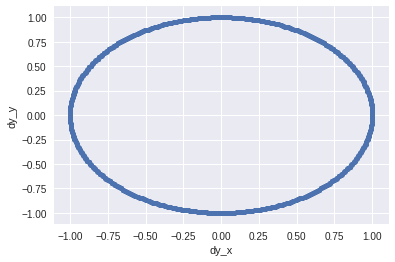

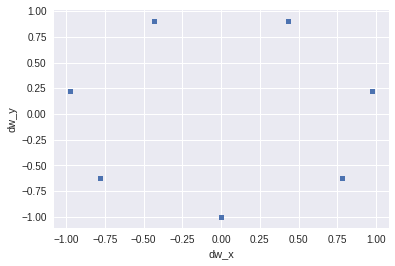

In [26]:
# Convert day of year and day of week numbers to coordinates of a point
# on a circle. This way day of year and day of week will become periodic 
# data
# first convert days to scale
df['day_week'] = df['datetime'].dt.dayofweek*(360/7)
df['day_year'] = df['datetime'].dt.dayofyear*(360/365)
# then convert scales to coordinates on 1 radius circle
# rad = 4.0*atan(1.0)/180
df['dw_x'] = -np.sin((4.0*np.arctan(1.0)/180)*df['day_week'])
df['dw_y'] = -np.cos((4.0*np.arctan(1.0)/180)*df['day_week'])
df['dy_x'] = -np.sin((4.0*np.arctan(1.0)/180)*df['day_year'])
df['dy_y'] = -np.cos((4.0*np.arctan(1.0)/180)*df['day_year'])

df.plot.scatter(x='dy_x', y='dy_y')
df.plot.scatter(x='dw_x', y='dw_y')

On a given day we know the weather (in general from forecast) and the airpollution a day before (Teleki_ystd). So we add to a row of parameters the airpollution of the prior day, and the air pollution of the given day (Teleki) will be our label. We want our forecast as close to this label as possible.

In [27]:
# make the yesterday day column
df['Teleki_ystd'] = df['Teleki'].shift(+1)
# fill the missing day value with next day
df['Teleki_ystd'] = df['Teleki_ystd'].fillna(method='bfill')
# reorder columns, last column will be the label data
df = df[[   'datetime',
            'dy_x',
            'dy_y',
            'dw_x',
            'dw_y',
            'temp_avr', 
            'temp_max', 
            'temp_min', 
            'pres', 
            'u', 
            'v',
            'prec',
            'Teleki_ystd',
            'Teleki']]
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,datetime,dy_x,dy_y,dw_x,dw_y,temp_avr,temp_max,temp_min,pres,u,v,prec,Teleki_ystd,Teleki
0,2011-01-01,-0.017213,-0.999852,0.974928,0.222521,-1.713034,-1.800535,-1.591323,0.415106,0.426107,1.128143,-0.329747,2.001368,2.001368
1,2011-01-02,-0.034422,-0.999407,0.781831,-0.623490,-1.491919,-1.349055,-1.604099,0.091325,0.756326,0.312022,-0.329747,2.001368,0.179151
2,2011-01-03,-0.051620,-0.998667,-0.000000,-1.000000,-1.861712,-1.800535,-1.987373,0.682961,-0.429758,-0.032814,-0.329747,0.179151,0.715097
3,2011-01-04,-0.068802,-0.997630,-0.781831,-0.623490,-1.856109,-1.957571,-1.706306,1.137725,-0.246448,1.152451,-0.329747,0.715097,0.554313
4,2011-01-05,-0.085965,-0.996298,-0.974928,0.222521,-1.893929,-2.036089,-1.706306,1.109027,-1.300392,1.448640,-0.329747,0.554313,0.286340


Split the database to train, validation and test data.

In [28]:
# build the pytorch train, validation and test sets
# train data
mask = (df['datetime'] < '2017-01-01')
df_train = df.loc[mask].drop(columns=['datetime'])
# train tensors
train_data = torch.tensor(df_train.values).float()
print(train_data.shape)

# validation data
mask = (df['datetime'] < '2018-01-01') & (df['datetime'] >= '2017-01-01')
df_valid = df.loc[mask].drop(columns=['datetime'])
# validation tensors
valid_data = torch.tensor(df_valid.values).float()
print(valid_data.shape)

# test data
mask = (df['datetime'] >= '2018-01-01')
df_test = df.loc[mask].drop(columns=['datetime'])
# validation tensors
test_data = torch.tensor(df_test.values).float()
print(test_data.shape)

torch.Size([2192, 13])
torch.Size([365, 13])
torch.Size([361, 13])


In [29]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


Here we instantiate our model.

In [31]:
# define and print the net
number_of_features = train_data.shape[1] - 1 # -1 because last column is label
n_hidden=512
n_layers=3
net = pmod.instantiate_model(number_of_features, 1, n_hidden, n_layers, train_on_gpu)
print(net)

LSTMForecaster(
  (lstm): LSTM(12, 512, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


We train our model. During training the step with the smallest validation loss will be saved. Later we will load back the modell with the smallest loss.
We compare two versions: 
1. data is loaded without periodic parameters of date - file: 'cp_base.pth'
2. data is loaded with periodic parameters of date - file: 'cp_withtimeperiod.pth'

model saved with 0.9645927771925926 mean_val_loss
Epoch: 1/100... Step: 4 train_loss: 0.5845... mean_val_loss: 0.9646
model saved with 0.8563706260174513 mean_val_loss
Epoch: 1/100... Step: 8 train_loss: 1.5772... mean_val_loss: 0.8564
model saved with 0.8138805391887823 mean_val_loss
Epoch: 1/100... Step: 12 train_loss: 0.7615... mean_val_loss: 0.8139
model saved with 0.7801836943253875 mean_val_loss
Epoch: 2/100... Step: 16 train_loss: 0.5216... mean_val_loss: 0.7802


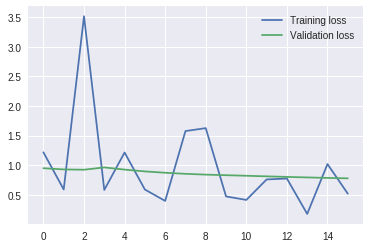

model saved with 0.7515802830457687 mean_val_loss
Epoch: 2/100... Step: 20 train_loss: 0.3323... mean_val_loss: 0.7516
model saved with 0.7466134441395601 mean_val_loss
Epoch: 2/100... Step: 24 train_loss: 0.5565... mean_val_loss: 0.7466
model saved with 0.7238466425665787 mean_val_loss
Epoch: 2/100... Step: 28 train_loss: 0.2513... mean_val_loss: 0.7238
model saved with 0.6956599205732346 mean_val_loss
Epoch: 3/100... Step: 32 train_loss: 0.2558... mean_val_loss: 0.6957


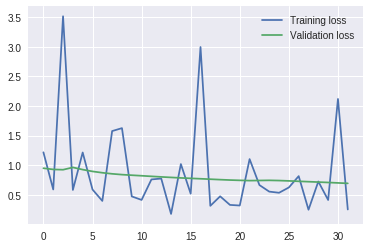

model saved with 0.6742405427826775 mean_val_loss
Epoch: 3/100... Step: 36 train_loss: 0.9176... mean_val_loss: 0.6742
model saved with 0.6533317621797323 mean_val_loss
Epoch: 3/100... Step: 40 train_loss: 0.5113... mean_val_loss: 0.6533
model saved with 0.6315199641341512 mean_val_loss
Epoch: 4/100... Step: 44 train_loss: 0.3590... mean_val_loss: 0.6315
model saved with 0.6094553340226412 mean_val_loss
Epoch: 4/100... Step: 48 train_loss: 0.2305... mean_val_loss: 0.6095


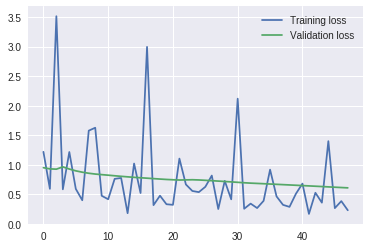

model saved with 0.5869695114401671 mean_val_loss
Epoch: 4/100... Step: 52 train_loss: 0.2500... mean_val_loss: 0.5870
model saved with 0.5688125001532691 mean_val_loss
Epoch: 4/100... Step: 56 train_loss: 0.1041... mean_val_loss: 0.5688
model saved with 0.5513528060168028 mean_val_loss
Epoch: 5/100... Step: 60 train_loss: 0.2049... mean_val_loss: 0.5514
model saved with 0.5361991770332679 mean_val_loss
Epoch: 5/100... Step: 64 train_loss: 0.7072... mean_val_loss: 0.5362


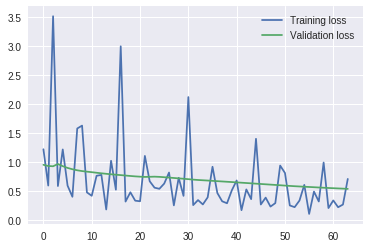

model saved with 0.5205729282735025 mean_val_loss
Epoch: 5/100... Step: 68 train_loss: 0.2927... mean_val_loss: 0.5206
model saved with 0.5067095302252306 mean_val_loss
Epoch: 6/100... Step: 72 train_loss: 0.3006... mean_val_loss: 0.5067
model saved with 0.4977706656056015 mean_val_loss
Epoch: 6/100... Step: 76 train_loss: 0.2182... mean_val_loss: 0.4978
model saved with 0.49052653918042777 mean_val_loss
Epoch: 6/100... Step: 80 train_loss: 0.2262... mean_val_loss: 0.4905


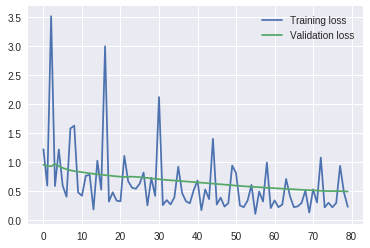

model saved with 0.47983651395354954 mean_val_loss
Epoch: 6/100... Step: 84 train_loss: 0.1490... mean_val_loss: 0.4798
model saved with 0.47007417848164385 mean_val_loss
Epoch: 7/100... Step: 88 train_loss: 0.2014... mean_val_loss: 0.4701
model saved with 0.4634139695731194 mean_val_loss
Epoch: 7/100... Step: 92 train_loss: 0.7536... mean_val_loss: 0.4634
model saved with 0.455617540050298 mean_val_loss
Epoch: 7/100... Step: 96 train_loss: 0.2272... mean_val_loss: 0.4556


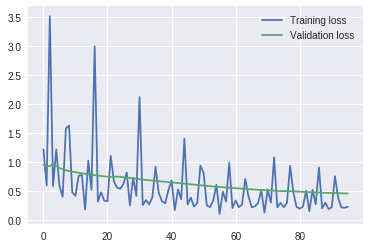

model saved with 0.4467108190059662 mean_val_loss
Epoch: 8/100... Step: 100 train_loss: 0.2736... mean_val_loss: 0.4467
model saved with 0.4384665463406306 mean_val_loss
Epoch: 8/100... Step: 104 train_loss: 0.1752... mean_val_loss: 0.4385
model saved with 0.4331322878047272 mean_val_loss
Epoch: 8/100... Step: 108 train_loss: 0.2205... mean_val_loss: 0.4331
model saved with 0.42886404786258936 mean_val_loss
Epoch: 8/100... Step: 112 train_loss: 0.0763... mean_val_loss: 0.4289


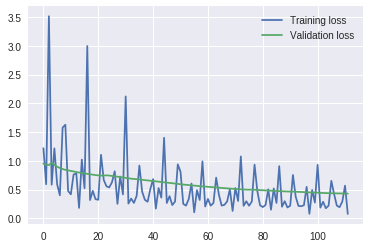

model saved with 0.42257558316763105 mean_val_loss
Epoch: 9/100... Step: 116 train_loss: 0.1935... mean_val_loss: 0.4226
model saved with 0.41639543933173023 mean_val_loss
Epoch: 9/100... Step: 120 train_loss: 0.6661... mean_val_loss: 0.4164
model saved with 0.41097957460630324 mean_val_loss
Epoch: 9/100... Step: 124 train_loss: 0.2056... mean_val_loss: 0.4110
model saved with 0.406394285033457 mean_val_loss
Epoch: 10/100... Step: 128 train_loss: 0.2937... mean_val_loss: 0.4064


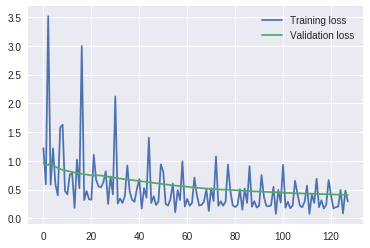

model saved with 0.40107851520632254 mean_val_loss
Epoch: 10/100... Step: 132 train_loss: 0.1859... mean_val_loss: 0.4011
model saved with 0.39589718356728554 mean_val_loss
Epoch: 10/100... Step: 136 train_loss: 0.1845... mean_val_loss: 0.3959
model saved with 0.3912616402442966 mean_val_loss
Epoch: 10/100... Step: 140 train_loss: 0.0691... mean_val_loss: 0.3913
model saved with 0.38702959686310756 mean_val_loss
Epoch: 11/100... Step: 144 train_loss: 0.1747... mean_val_loss: 0.3870


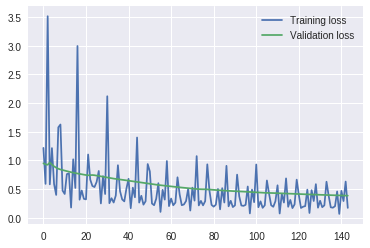

model saved with 0.38262616427665624 mean_val_loss
Epoch: 11/100... Step: 148 train_loss: 0.5950... mean_val_loss: 0.3826
model saved with 0.3785270346377633 mean_val_loss
Epoch: 11/100... Step: 152 train_loss: 0.2090... mean_val_loss: 0.3785
model saved with 0.3745893896915592 mean_val_loss
Epoch: 12/100... Step: 156 train_loss: 0.2487... mean_val_loss: 0.3746
model saved with 0.3722720344318077 mean_val_loss
Epoch: 12/100... Step: 160 train_loss: 0.1951... mean_val_loss: 0.3723


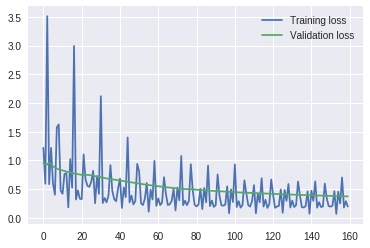

model saved with 0.3698008763944594 mean_val_loss
Epoch: 12/100... Step: 164 train_loss: 0.1818... mean_val_loss: 0.3698
model saved with 0.367231611539388 mean_val_loss
Epoch: 12/100... Step: 168 train_loss: 0.1535... mean_val_loss: 0.3672
model saved with 0.36468187071989444 mean_val_loss
Epoch: 13/100... Step: 172 train_loss: 0.1781... mean_val_loss: 0.3647
Epoch: 13/100... Step: 176 train_loss: 0.8327... mean_val_loss: 0.3651


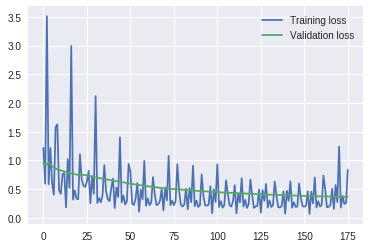

model saved with 0.36312570830600127 mean_val_loss
Epoch: 13/100... Step: 180 train_loss: 0.2532... mean_val_loss: 0.3631
model saved with 0.36086578345250175 mean_val_loss
Epoch: 14/100... Step: 184 train_loss: 0.2554... mean_val_loss: 0.3609
model saved with 0.35866123229820046 mean_val_loss
Epoch: 14/100... Step: 188 train_loss: 0.1592... mean_val_loss: 0.3587
model saved with 0.357501210741854 mean_val_loss
Epoch: 14/100... Step: 192 train_loss: 0.2291... mean_val_loss: 0.3575


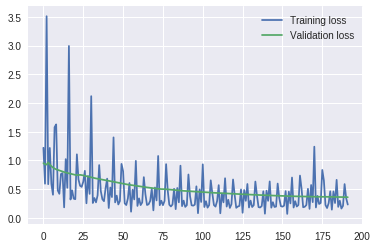

model saved with 0.35550135011043477 mean_val_loss
Epoch: 14/100... Step: 196 train_loss: 0.0662... mean_val_loss: 0.3555
model saved with 0.3529010367579758 mean_val_loss
Epoch: 15/100... Step: 200 train_loss: 0.1813... mean_val_loss: 0.3529
model saved with 0.3514315457649383 mean_val_loss
Epoch: 15/100... Step: 204 train_loss: 0.6567... mean_val_loss: 0.3514
model saved with 0.34931177678159797 mean_val_loss
Epoch: 15/100... Step: 208 train_loss: 0.1966... mean_val_loss: 0.3493


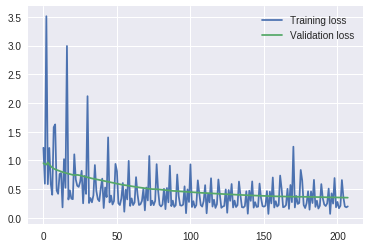

model saved with 0.34670446401918836 mean_val_loss
Epoch: 16/100... Step: 212 train_loss: 0.2360... mean_val_loss: 0.3467
model saved with 0.3447604906331334 mean_val_loss
Epoch: 16/100... Step: 216 train_loss: 0.1657... mean_val_loss: 0.3448
Epoch: 16/100... Step: 220 train_loss: 0.2252... mean_val_loss: 0.3452
Epoch: 16/100... Step: 224 train_loss: 0.0874... mean_val_loss: 0.3450


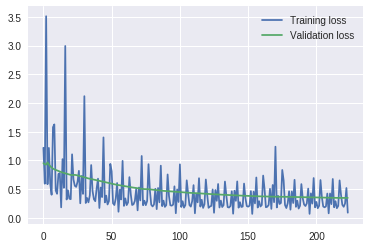

model saved with 0.34319812472778977 mean_val_loss
Epoch: 17/100... Step: 228 train_loss: 0.1939... mean_val_loss: 0.3432
model saved with 0.3412592633434668 mean_val_loss
Epoch: 17/100... Step: 232 train_loss: 0.7058... mean_val_loss: 0.3413
model saved with 0.33950721584576166 mean_val_loss
Epoch: 17/100... Step: 236 train_loss: 0.2156... mean_val_loss: 0.3395
model saved with 0.33790296913745504 mean_val_loss
Epoch: 18/100... Step: 240 train_loss: 0.2412... mean_val_loss: 0.3379


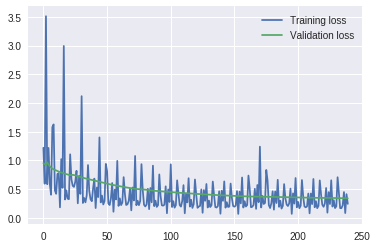

model saved with 0.3361461905029709 mean_val_loss
Epoch: 18/100... Step: 244 train_loss: 0.1638... mean_val_loss: 0.3361
model saved with 0.3342807544996181 mean_val_loss
Epoch: 18/100... Step: 248 train_loss: 0.1652... mean_val_loss: 0.3343
model saved with 0.33245132122898385 mean_val_loss
Epoch: 18/100... Step: 252 train_loss: 0.0576... mean_val_loss: 0.3325
model saved with 0.33074130602471996 mean_val_loss
Epoch: 19/100... Step: 256 train_loss: 0.1915... mean_val_loss: 0.3307


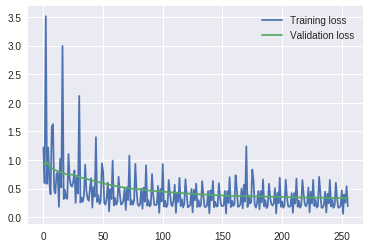

model saved with 0.3295393719552801 mean_val_loss
Epoch: 19/100... Step: 260 train_loss: 0.5721... mean_val_loss: 0.3295
model saved with 0.3280617420730943 mean_val_loss
Epoch: 19/100... Step: 264 train_loss: 0.1775... mean_val_loss: 0.3281
model saved with 0.3263355238752356 mean_val_loss
Epoch: 20/100... Step: 268 train_loss: 0.2152... mean_val_loss: 0.3263
model saved with 0.3254565732580993 mean_val_loss
Epoch: 20/100... Step: 272 train_loss: 0.1736... mean_val_loss: 0.3255


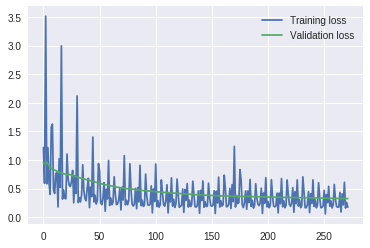

model saved with 0.3249097717790932 mean_val_loss
Epoch: 20/100... Step: 276 train_loss: 0.1784... mean_val_loss: 0.3249
model saved with 0.3232910780236125 mean_val_loss
Epoch: 20/100... Step: 280 train_loss: 0.0950... mean_val_loss: 0.3233
model saved with 0.32177353559822686 mean_val_loss
Epoch: 21/100... Step: 284 train_loss: 0.1749... mean_val_loss: 0.3218
Epoch: 21/100... Step: 288 train_loss: 0.5868... mean_val_loss: 0.3224


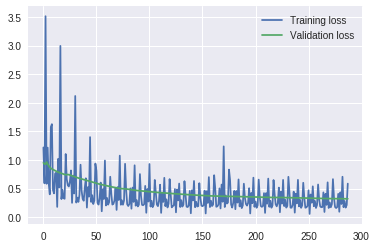

Epoch: 21/100... Step: 292 train_loss: 0.2106... mean_val_loss: 0.3226
model saved with 0.321338145251109 mean_val_loss
Epoch: 22/100... Step: 296 train_loss: 0.2540... mean_val_loss: 0.3213
model saved with 0.3199082507068912 mean_val_loss
Epoch: 22/100... Step: 300 train_loss: 0.1501... mean_val_loss: 0.3199
model saved with 0.3185684078397523 mean_val_loss
Epoch: 22/100... Step: 304 train_loss: 0.1847... mean_val_loss: 0.3186


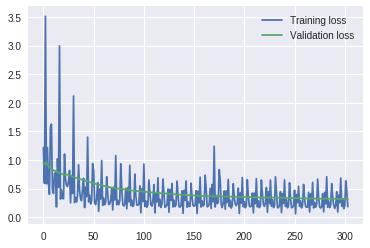

model saved with 0.3177101876368964 mean_val_loss
Epoch: 22/100... Step: 308 train_loss: 0.0658... mean_val_loss: 0.3177
model saved with 0.3165954545450707 mean_val_loss
Epoch: 23/100... Step: 312 train_loss: 0.1857... mean_val_loss: 0.3166
model saved with 0.3158076727244107 mean_val_loss
Epoch: 23/100... Step: 316 train_loss: 0.5661... mean_val_loss: 0.3158
model saved with 0.3146995625924319 mean_val_loss
Epoch: 23/100... Step: 320 train_loss: 0.1786... mean_val_loss: 0.3147


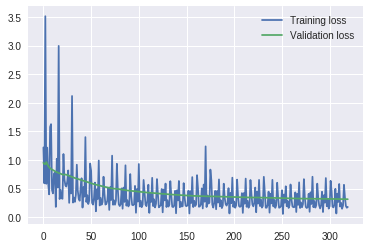

model saved with 0.31332998211139146 mean_val_loss
Epoch: 24/100... Step: 324 train_loss: 0.2544... mean_val_loss: 0.3133
model saved with 0.31219159685665876 mean_val_loss
Epoch: 24/100... Step: 328 train_loss: 0.1481... mean_val_loss: 0.3122
Epoch: 24/100... Step: 332 train_loss: 0.2199... mean_val_loss: 0.3122
model saved with 0.3120070403730053 mean_val_loss
Epoch: 24/100... Step: 336 train_loss: 0.0820... mean_val_loss: 0.3120


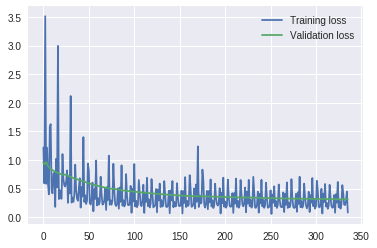

model saved with 0.3110470740343718 mean_val_loss
Epoch: 25/100... Step: 340 train_loss: 0.1768... mean_val_loss: 0.3110
model saved with 0.3100927237876106 mean_val_loss
Epoch: 25/100... Step: 344 train_loss: 0.5760... mean_val_loss: 0.3101
model saved with 0.30937007445328196 mean_val_loss
Epoch: 25/100... Step: 348 train_loss: 0.1646... mean_val_loss: 0.3094
model saved with 0.3084331165935675 mean_val_loss
Epoch: 26/100... Step: 352 train_loss: 0.2540... mean_val_loss: 0.3084


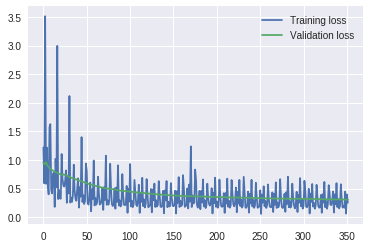

model saved with 0.3072026985686984 mean_val_loss
Epoch: 26/100... Step: 356 train_loss: 0.1506... mean_val_loss: 0.3072
model saved with 0.30600941518528596 mean_val_loss
Epoch: 26/100... Step: 360 train_loss: 0.1827... mean_val_loss: 0.3060
model saved with 0.30508009012747594 mean_val_loss
Epoch: 26/100... Step: 364 train_loss: 0.0631... mean_val_loss: 0.3051
model saved with 0.3041467112691506 mean_val_loss
Epoch: 27/100... Step: 368 train_loss: 0.1607... mean_val_loss: 0.3041


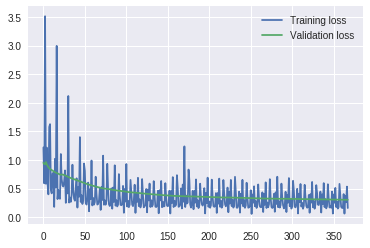

model saved with 0.30311769152921375 mean_val_loss
Epoch: 27/100... Step: 372 train_loss: 0.5157... mean_val_loss: 0.3031
model saved with 0.3020462544357523 mean_val_loss
Epoch: 27/100... Step: 376 train_loss: 0.1765... mean_val_loss: 0.3020
model saved with 0.3009514127710932 mean_val_loss
Epoch: 28/100... Step: 380 train_loss: 0.2181... mean_val_loss: 0.3010
model saved with 0.30055992302368395 mean_val_loss
Epoch: 28/100... Step: 384 train_loss: 0.1512... mean_val_loss: 0.3006


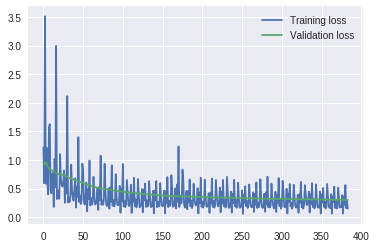

model saved with 0.30050476423474315 mean_val_loss
Epoch: 28/100... Step: 388 train_loss: 0.1777... mean_val_loss: 0.3005
model saved with 0.29958232328751866 mean_val_loss
Epoch: 28/100... Step: 392 train_loss: 0.1088... mean_val_loss: 0.2996
model saved with 0.29864799984815443 mean_val_loss
Epoch: 29/100... Step: 396 train_loss: 0.1671... mean_val_loss: 0.2986
Epoch: 29/100... Step: 400 train_loss: 0.5178... mean_val_loss: 0.2990


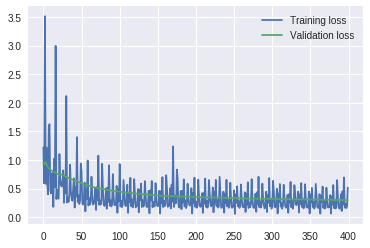

Epoch: 29/100... Step: 404 train_loss: 0.2715... mean_val_loss: 0.2995
Epoch: 30/100... Step: 408 train_loss: 0.2148... mean_val_loss: 0.2989
model saved with 0.2982698509252621 mean_val_loss
Epoch: 30/100... Step: 412 train_loss: 0.1446... mean_val_loss: 0.2983
model saved with 0.29772314546593964 mean_val_loss
Epoch: 30/100... Step: 416 train_loss: 0.2070... mean_val_loss: 0.2977


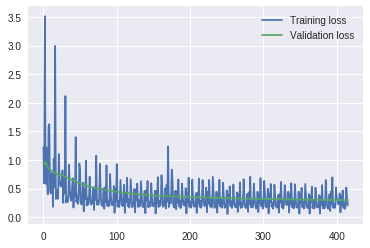

model saved with 0.29719774085318756 mean_val_loss
Epoch: 30/100... Step: 420 train_loss: 0.0657... mean_val_loss: 0.2972
model saved with 0.29637599913930557 mean_val_loss
Epoch: 31/100... Step: 424 train_loss: 0.1485... mean_val_loss: 0.2964
model saved with 0.2954819545184619 mean_val_loss
Epoch: 31/100... Step: 428 train_loss: 0.6688... mean_val_loss: 0.2955
model saved with 0.29464758519531675 mean_val_loss
Epoch: 31/100... Step: 432 train_loss: 0.1745... mean_val_loss: 0.2946


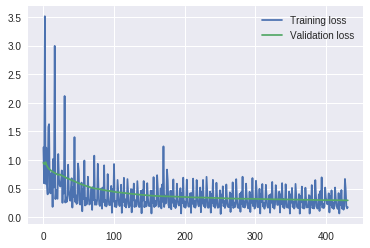

model saved with 0.2939519700636968 mean_val_loss
Epoch: 32/100... Step: 436 train_loss: 0.2128... mean_val_loss: 0.2940
model saved with 0.2934808001006869 mean_val_loss
Epoch: 32/100... Step: 440 train_loss: 0.1372... mean_val_loss: 0.2935
model saved with 0.29291537586129734 mean_val_loss
Epoch: 32/100... Step: 444 train_loss: 0.1972... mean_val_loss: 0.2929
model saved with 0.2921107854012267 mean_val_loss
Epoch: 32/100... Step: 448 train_loss: 0.0621... mean_val_loss: 0.2921


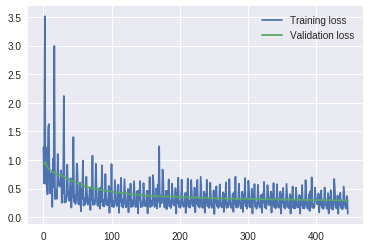

model saved with 0.2913646814949085 mean_val_loss
Epoch: 33/100... Step: 452 train_loss: 0.1589... mean_val_loss: 0.2914
Epoch: 33/100... Step: 456 train_loss: 0.5593... mean_val_loss: 0.2925
Epoch: 33/100... Step: 460 train_loss: 0.2412... mean_val_loss: 0.2940
Epoch: 34/100... Step: 464 train_loss: 0.2004... mean_val_loss: 0.2936


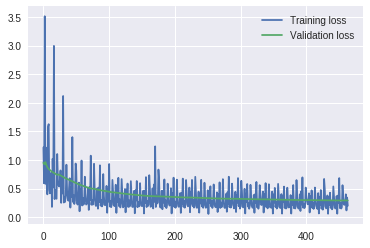

Epoch: 34/100... Step: 468 train_loss: 0.1590... mean_val_loss: 0.2929
Epoch: 34/100... Step: 472 train_loss: 0.1965... mean_val_loss: 0.2921
model saved with 0.29135873083400876 mean_val_loss
Epoch: 34/100... Step: 476 train_loss: 0.0783... mean_val_loss: 0.2914
model saved with 0.29052485852347065 mean_val_loss
Epoch: 35/100... Step: 480 train_loss: 0.1638... mean_val_loss: 0.2905


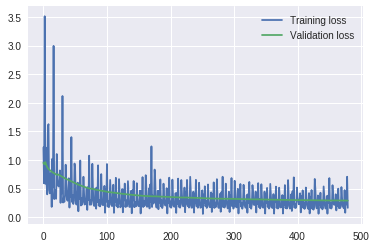

model saved with 0.289736978948301 mean_val_loss
Epoch: 35/100... Step: 484 train_loss: 0.4693... mean_val_loss: 0.2897
model saved with 0.2889142093462411 mean_val_loss
Epoch: 35/100... Step: 488 train_loss: 0.1380... mean_val_loss: 0.2889
model saved with 0.28811111471547585 mean_val_loss
Epoch: 36/100... Step: 492 train_loss: 0.2076... mean_val_loss: 0.2881
model saved with 0.2875924876275202 mean_val_loss
Epoch: 36/100... Step: 496 train_loss: 0.1339... mean_val_loss: 0.2876


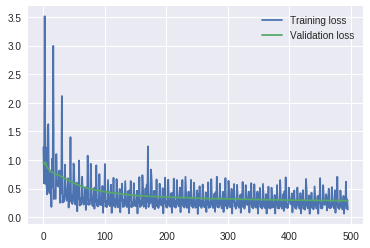

model saved with 0.2873465622514486 mean_val_loss
Epoch: 36/100... Step: 500 train_loss: 0.1878... mean_val_loss: 0.2873
model saved with 0.28695554264067186 mean_val_loss
Epoch: 36/100... Step: 504 train_loss: 0.0860... mean_val_loss: 0.2870
model saved with 0.2863447804766612 mean_val_loss
Epoch: 37/100... Step: 508 train_loss: 0.1490... mean_val_loss: 0.2863
model saved with 0.28557309450843604 mean_val_loss
Epoch: 37/100... Step: 512 train_loss: 0.5467... mean_val_loss: 0.2856


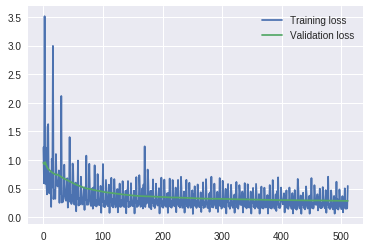

model saved with 0.2849676965901902 mean_val_loss
Epoch: 37/100... Step: 516 train_loss: 0.1640... mean_val_loss: 0.2850
model saved with 0.2844150226348295 mean_val_loss
Epoch: 38/100... Step: 520 train_loss: 0.2411... mean_val_loss: 0.2844
model saved with 0.2838604164075192 mean_val_loss
Epoch: 38/100... Step: 524 train_loss: 0.1307... mean_val_loss: 0.2839
model saved with 0.2833057501720208 mean_val_loss
Epoch: 38/100... Step: 528 train_loss: 0.1940... mean_val_loss: 0.2833


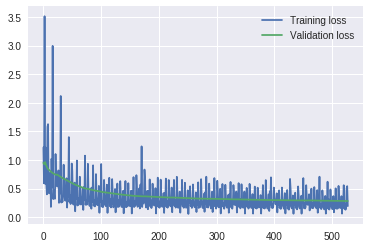

model saved with 0.28264991598749967 mean_val_loss
Epoch: 38/100... Step: 532 train_loss: 0.0781... mean_val_loss: 0.2826
model saved with 0.2820144316820956 mean_val_loss
Epoch: 39/100... Step: 536 train_loss: 0.1606... mean_val_loss: 0.2820
Epoch: 39/100... Step: 540 train_loss: 0.5747... mean_val_loss: 0.2822
Epoch: 39/100... Step: 544 train_loss: 0.2939... mean_val_loss: 0.2828


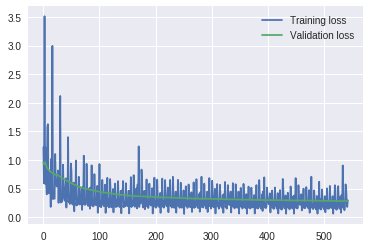

Epoch: 40/100... Step: 548 train_loss: 0.2089... mean_val_loss: 0.2825
Epoch: 40/100... Step: 552 train_loss: 0.1489... mean_val_loss: 0.2822
Epoch: 40/100... Step: 556 train_loss: 0.1875... mean_val_loss: 0.2821
Epoch: 40/100... Step: 560 train_loss: 0.0668... mean_val_loss: 0.2821


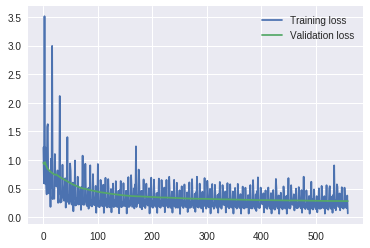

model saved with 0.2815958483157851 mean_val_loss
Epoch: 41/100... Step: 564 train_loss: 0.1564... mean_val_loss: 0.2816
model saved with 0.28096929065306003 mean_val_loss
Epoch: 41/100... Step: 568 train_loss: 0.5006... mean_val_loss: 0.2810
model saved with 0.28047808584060285 mean_val_loss
Epoch: 41/100... Step: 572 train_loss: 0.1420... mean_val_loss: 0.2805
model saved with 0.2799880934956794 mean_val_loss
Epoch: 42/100... Step: 576 train_loss: 0.2227... mean_val_loss: 0.2800


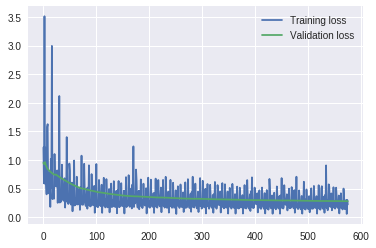

model saved with 0.2794607211803568 mean_val_loss
Epoch: 42/100... Step: 580 train_loss: 0.1207... mean_val_loss: 0.2795
model saved with 0.2789362393166513 mean_val_loss
Epoch: 42/100... Step: 584 train_loss: 0.1787... mean_val_loss: 0.2789
model saved with 0.2783197388939914 mean_val_loss
Epoch: 42/100... Step: 588 train_loss: 0.0596... mean_val_loss: 0.2783
model saved with 0.27773650322184973 mean_val_loss
Epoch: 43/100... Step: 592 train_loss: 0.1451... mean_val_loss: 0.2777


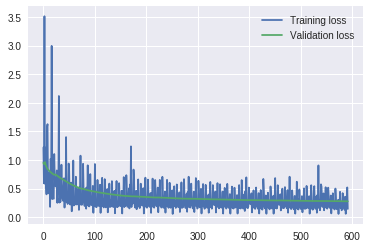

Epoch: 43/100... Step: 596 train_loss: 0.4440... mean_val_loss: 0.2778
Epoch: 43/100... Step: 600 train_loss: 0.2048... mean_val_loss: 0.2784
Epoch: 44/100... Step: 604 train_loss: 0.1883... mean_val_loss: 0.2781
model saved with 0.27759529462721394 mean_val_loss
Epoch: 44/100... Step: 608 train_loss: 0.1319... mean_val_loss: 0.2776


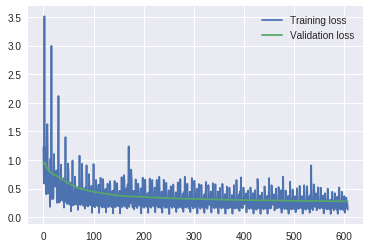

model saved with 0.2770725668353193 mean_val_loss
Epoch: 44/100... Step: 612 train_loss: 0.1774... mean_val_loss: 0.2771
model saved with 0.2765947836027904 mean_val_loss
Epoch: 44/100... Step: 616 train_loss: 0.0819... mean_val_loss: 0.2766
model saved with 0.27608790171723213 mean_val_loss
Epoch: 45/100... Step: 620 train_loss: 0.1374... mean_val_loss: 0.2761
model saved with 0.2755788697932775 mean_val_loss
Epoch: 45/100... Step: 624 train_loss: 0.4516... mean_val_loss: 0.2756


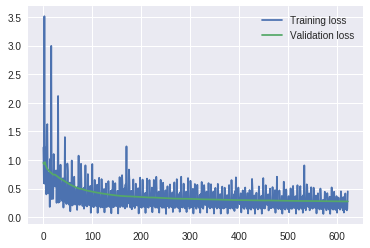

model saved with 0.2751225641554898 mean_val_loss
Epoch: 45/100... Step: 628 train_loss: 0.1237... mean_val_loss: 0.2751
model saved with 0.2747064282693252 mean_val_loss
Epoch: 46/100... Step: 632 train_loss: 0.1871... mean_val_loss: 0.2747
model saved with 0.2746207595058957 mean_val_loss
Epoch: 46/100... Step: 636 train_loss: 0.1068... mean_val_loss: 0.2746
Epoch: 46/100... Step: 640 train_loss: 0.1782... mean_val_loss: 0.2747


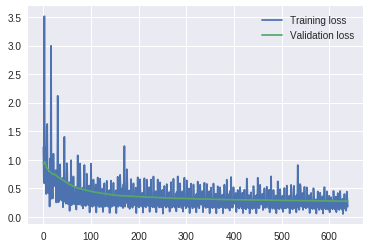

model saved with 0.27423547397465997 mean_val_loss
Epoch: 46/100... Step: 644 train_loss: 0.0623... mean_val_loss: 0.2742
model saved with 0.2737799006238304 mean_val_loss
Epoch: 47/100... Step: 648 train_loss: 0.1403... mean_val_loss: 0.2738
model saved with 0.2732755196755009 mean_val_loss
Epoch: 47/100... Step: 652 train_loss: 0.4192... mean_val_loss: 0.2733
model saved with 0.2730768823530525 mean_val_loss
Epoch: 47/100... Step: 656 train_loss: 0.1153... mean_val_loss: 0.2731


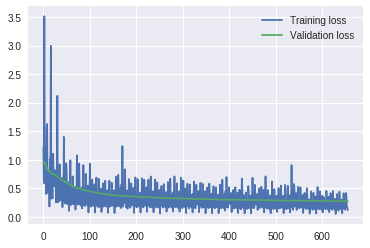

model saved with 0.27294952578729753 mean_val_loss
Epoch: 48/100... Step: 660 train_loss: 0.2029... mean_val_loss: 0.2729
model saved with 0.27258718143363136 mean_val_loss
Epoch: 48/100... Step: 664 train_loss: 0.1194... mean_val_loss: 0.2726
model saved with 0.2721753489438021 mean_val_loss
Epoch: 48/100... Step: 668 train_loss: 0.1628... mean_val_loss: 0.2722
model saved with 0.2717710736795284 mean_val_loss
Epoch: 48/100... Step: 672 train_loss: 0.0587... mean_val_loss: 0.2718


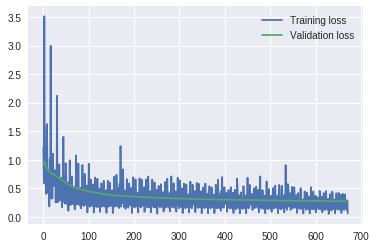

model saved with 0.27145339296744947 mean_val_loss
Epoch: 49/100... Step: 676 train_loss: 0.1457... mean_val_loss: 0.2715
model saved with 0.2711330044795485 mean_val_loss
Epoch: 49/100... Step: 680 train_loss: 0.3810... mean_val_loss: 0.2711
model saved with 0.27078292076612076 mean_val_loss
Epoch: 49/100... Step: 684 train_loss: 0.1604... mean_val_loss: 0.2708
model saved with 0.2703917255343566 mean_val_loss
Epoch: 50/100... Step: 688 train_loss: 0.1845... mean_val_loss: 0.2704


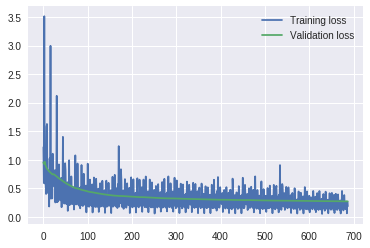

model saved with 0.2700372402787725 mean_val_loss
Epoch: 50/100... Step: 692 train_loss: 0.1219... mean_val_loss: 0.2700
model saved with 0.26978398223632366 mean_val_loss
Epoch: 50/100... Step: 696 train_loss: 0.1595... mean_val_loss: 0.2698
model saved with 0.26946729307728157 mean_val_loss
Epoch: 50/100... Step: 700 train_loss: 0.0560... mean_val_loss: 0.2695
model saved with 0.2691206766493534 mean_val_loss
Epoch: 51/100... Step: 704 train_loss: 0.1320... mean_val_loss: 0.2691


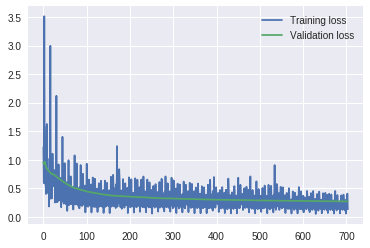

model saved with 0.2688958171470943 mean_val_loss
Epoch: 51/100... Step: 708 train_loss: 0.3549... mean_val_loss: 0.2689
Epoch: 51/100... Step: 712 train_loss: 0.1542... mean_val_loss: 0.2692
Epoch: 52/100... Step: 716 train_loss: 0.2044... mean_val_loss: 0.2694
Epoch: 52/100... Step: 720 train_loss: 0.1106... mean_val_loss: 0.2691


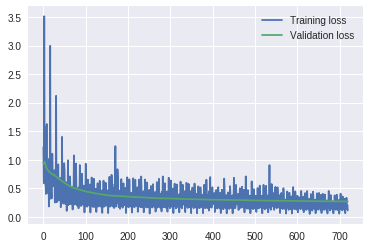

model saved with 0.26887233103548297 mean_val_loss
Epoch: 52/100... Step: 724 train_loss: 0.1470... mean_val_loss: 0.2689
model saved with 0.2686124678783037 mean_val_loss
Epoch: 52/100... Step: 728 train_loss: 0.0760... mean_val_loss: 0.2686
model saved with 0.26831007174781113 mean_val_loss
Epoch: 53/100... Step: 732 train_loss: 0.1602... mean_val_loss: 0.2683
model saved with 0.2681652651391114 mean_val_loss
Epoch: 53/100... Step: 736 train_loss: 0.4713... mean_val_loss: 0.2682


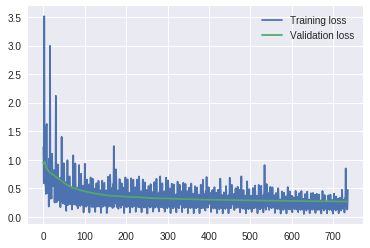

model saved with 0.2678582532180322 mean_val_loss
Epoch: 53/100... Step: 740 train_loss: 0.1743... mean_val_loss: 0.2679
model saved with 0.2676103546895007 mean_val_loss
Epoch: 54/100... Step: 744 train_loss: 0.1766... mean_val_loss: 0.2676
model saved with 0.2674590047189896 mean_val_loss
Epoch: 54/100... Step: 748 train_loss: 0.1611... mean_val_loss: 0.2675
Epoch: 54/100... Step: 752 train_loss: 0.2215... mean_val_loss: 0.2678


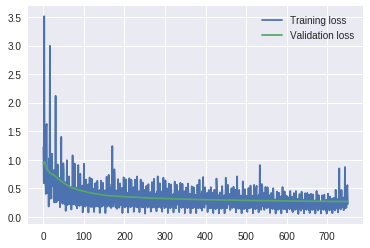

Epoch: 54/100... Step: 756 train_loss: 0.0993... mean_val_loss: 0.2680
Epoch: 55/100... Step: 760 train_loss: 0.1741... mean_val_loss: 0.2679
Epoch: 55/100... Step: 764 train_loss: 0.4961... mean_val_loss: 0.2678
Epoch: 55/100... Step: 768 train_loss: 0.1305... mean_val_loss: 0.2676


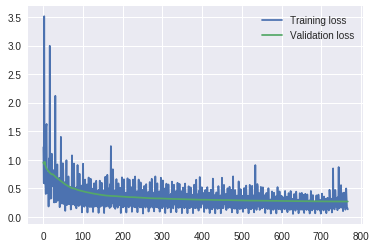

Epoch: 56/100... Step: 772 train_loss: 0.1992... mean_val_loss: 0.2675
model saved with 0.26724922808712903 mean_val_loss
Epoch: 56/100... Step: 776 train_loss: 0.1124... mean_val_loss: 0.2672
model saved with 0.26693055980289593 mean_val_loss
Epoch: 56/100... Step: 780 train_loss: 0.1513... mean_val_loss: 0.2669
model saved with 0.26659538723262294 mean_val_loss
Epoch: 56/100... Step: 784 train_loss: 0.0566... mean_val_loss: 0.2666


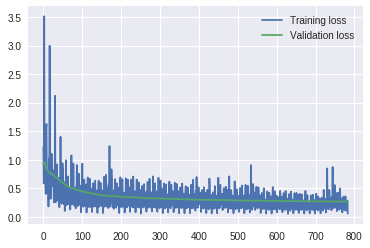

model saved with 0.26627745951152393 mean_val_loss
Epoch: 57/100... Step: 788 train_loss: 0.1351... mean_val_loss: 0.2663
model saved with 0.26608186188351474 mean_val_loss
Epoch: 57/100... Step: 792 train_loss: 0.2867... mean_val_loss: 0.2661
model saved with 0.26604630845837557 mean_val_loss
Epoch: 57/100... Step: 796 train_loss: 0.1123... mean_val_loss: 0.2660
model saved with 0.2659894430171698 mean_val_loss
Epoch: 58/100... Step: 800 train_loss: 0.1925... mean_val_loss: 0.2660


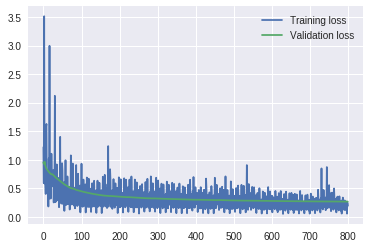

model saved with 0.2657464625990361 mean_val_loss
Epoch: 58/100... Step: 804 train_loss: 0.1068... mean_val_loss: 0.2657
model saved with 0.2654823424239265 mean_val_loss
Epoch: 58/100... Step: 808 train_loss: 0.1116... mean_val_loss: 0.2655
model saved with 0.2652683789048142 mean_val_loss
Epoch: 58/100... Step: 812 train_loss: 0.0588... mean_val_loss: 0.2653
model saved with 0.26506895462379737 mean_val_loss
Epoch: 59/100... Step: 816 train_loss: 0.1237... mean_val_loss: 0.2651


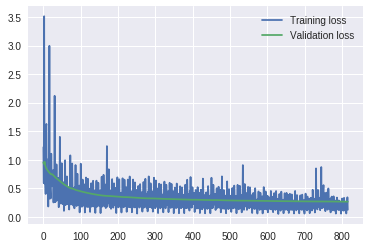

model saved with 0.2649323201488431 mean_val_loss
Epoch: 59/100... Step: 820 train_loss: 0.3018... mean_val_loss: 0.2649
model saved with 0.26473299790065263 mean_val_loss
Epoch: 59/100... Step: 824 train_loss: 0.1177... mean_val_loss: 0.2647
model saved with 0.2644709235840086 mean_val_loss
Epoch: 60/100... Step: 828 train_loss: 0.2042... mean_val_loss: 0.2645
model saved with 0.2642664397896554 mean_val_loss
Epoch: 60/100... Step: 832 train_loss: 0.0986... mean_val_loss: 0.2643


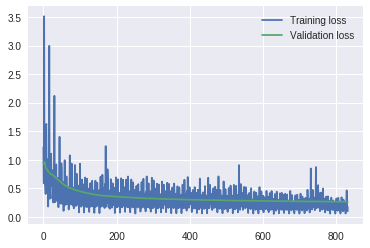

Epoch: 60/100... Step: 836 train_loss: 0.1239... mean_val_loss: 0.2644
Epoch: 60/100... Step: 840 train_loss: 0.0615... mean_val_loss: 0.2647
Epoch: 61/100... Step: 844 train_loss: 0.1406... mean_val_loss: 0.2646
Epoch: 61/100... Step: 848 train_loss: 0.4216... mean_val_loss: 0.2645


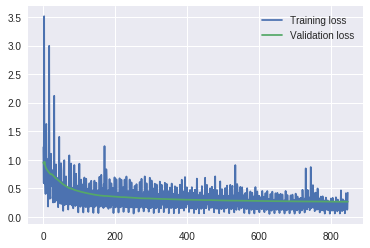

Epoch: 61/100... Step: 852 train_loss: 0.1263... mean_val_loss: 0.2644
Epoch: 62/100... Step: 856 train_loss: 0.1749... mean_val_loss: 0.2643
model saved with 0.2641461617161715 mean_val_loss
Epoch: 62/100... Step: 860 train_loss: 0.1161... mean_val_loss: 0.2641
model saved with 0.2639898371201492 mean_val_loss
Epoch: 62/100... Step: 864 train_loss: 0.1581... mean_val_loss: 0.2640


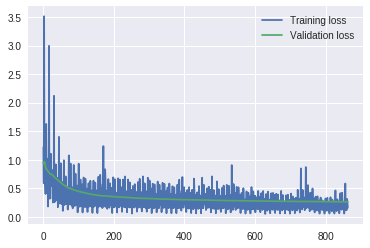

model saved with 0.2637532211471057 mean_val_loss
Epoch: 62/100... Step: 868 train_loss: 0.0768... mean_val_loss: 0.2638
model saved with 0.2634861111393147 mean_val_loss
Epoch: 63/100... Step: 872 train_loss: 0.1288... mean_val_loss: 0.2635
model saved with 0.26343967293104215 mean_val_loss
Epoch: 63/100... Step: 876 train_loss: 0.2998... mean_val_loss: 0.2634
Epoch: 63/100... Step: 880 train_loss: 0.1589... mean_val_loss: 0.2637


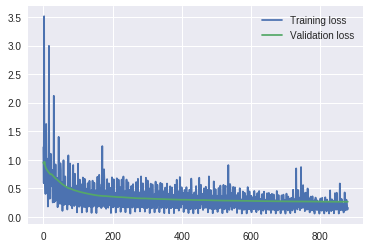

Epoch: 64/100... Step: 884 train_loss: 0.1317... mean_val_loss: 0.2637
Epoch: 64/100... Step: 888 train_loss: 0.1145... mean_val_loss: 0.2636
Epoch: 64/100... Step: 892 train_loss: 0.1105... mean_val_loss: 0.2636
Epoch: 64/100... Step: 896 train_loss: 0.0596... mean_val_loss: 0.2636


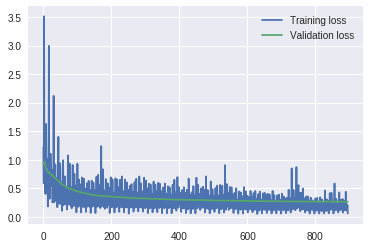

Epoch: 65/100... Step: 900 train_loss: 0.1153... mean_val_loss: 0.2637
Epoch: 65/100... Step: 904 train_loss: 0.3123... mean_val_loss: 0.2636
model saved with 0.2633772479321003 mean_val_loss
Epoch: 65/100... Step: 908 train_loss: 0.0981... mean_val_loss: 0.2634
model saved with 0.2631682170791911 mean_val_loss
Epoch: 66/100... Step: 912 train_loss: 0.1465... mean_val_loss: 0.2632


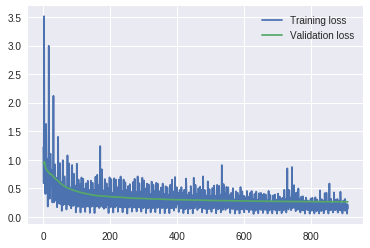

model saved with 0.2629934173101746 mean_val_loss
Epoch: 66/100... Step: 916 train_loss: 0.1123... mean_val_loss: 0.2630
model saved with 0.26296895855389857 mean_val_loss
Epoch: 66/100... Step: 920 train_loss: 0.1372... mean_val_loss: 0.2630
model saved with 0.26294264822666136 mean_val_loss
Epoch: 66/100... Step: 924 train_loss: 0.0621... mean_val_loss: 0.2629
model saved with 0.2629010133597807 mean_val_loss
Epoch: 67/100... Step: 928 train_loss: 0.1034... mean_val_loss: 0.2629


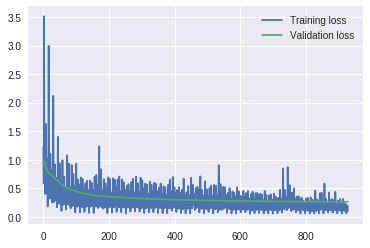

model saved with 0.2628978191727029 mean_val_loss
Epoch: 67/100... Step: 932 train_loss: 0.2900... mean_val_loss: 0.2629
Epoch: 67/100... Step: 936 train_loss: 0.0807... mean_val_loss: 0.2629
Epoch: 68/100... Step: 940 train_loss: 0.1613... mean_val_loss: 0.2630
Epoch: 68/100... Step: 944 train_loss: 0.0977... mean_val_loss: 0.2630


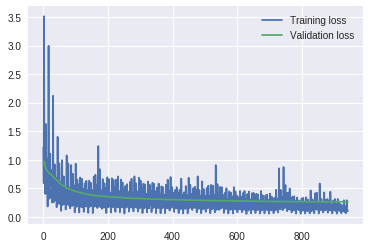

model saved with 0.2628333476658926 mean_val_loss
Epoch: 68/100... Step: 948 train_loss: 0.1082... mean_val_loss: 0.2628
model saved with 0.2627388125935084 mean_val_loss
Epoch: 68/100... Step: 952 train_loss: 0.0559... mean_val_loss: 0.2627
model saved with 0.26271031537019185 mean_val_loss
Epoch: 69/100... Step: 956 train_loss: 0.1050... mean_val_loss: 0.2627
Epoch: 69/100... Step: 960 train_loss: 0.2565... mean_val_loss: 0.2628


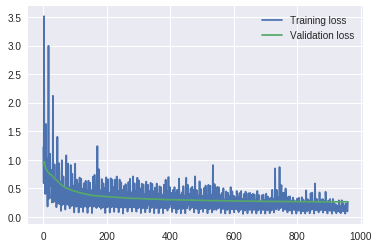

Epoch: 69/100... Step: 964 train_loss: 0.0804... mean_val_loss: 0.2628
Epoch: 70/100... Step: 968 train_loss: 0.1294... mean_val_loss: 0.2628
Epoch: 70/100... Step: 972 train_loss: 0.1096... mean_val_loss: 0.2628
Epoch: 70/100... Step: 976 train_loss: 0.0946... mean_val_loss: 0.2628


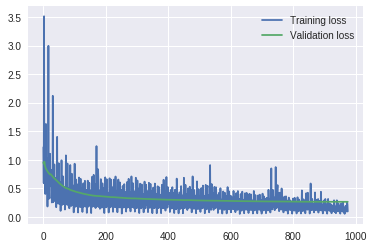

Epoch: 70/100... Step: 980 train_loss: 0.0508... mean_val_loss: 0.2629
Epoch: 71/100... Step: 984 train_loss: 0.1076... mean_val_loss: 0.2629
Epoch: 71/100... Step: 988 train_loss: 0.2748... mean_val_loss: 0.2628
Epoch: 71/100... Step: 992 train_loss: 0.0772... mean_val_loss: 0.2628


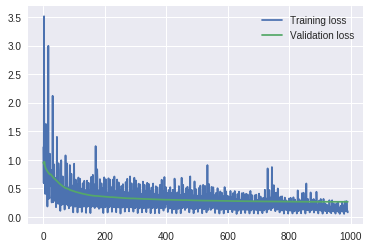

model saved with 0.26270100720840167 mean_val_loss
Epoch: 72/100... Step: 996 train_loss: 0.1402... mean_val_loss: 0.2627
model saved with 0.26270084935054183 mean_val_loss
Epoch: 72/100... Step: 1000 train_loss: 0.1081... mean_val_loss: 0.2627
Epoch: 72/100... Step: 1004 train_loss: 0.0897... mean_val_loss: 0.2627
model saved with 0.2626844272424009 mean_val_loss
Epoch: 72/100... Step: 1008 train_loss: 0.0768... mean_val_loss: 0.2627


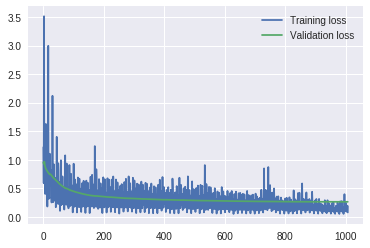

model saved with 0.26264860833306675 mean_val_loss
Epoch: 73/100... Step: 1012 train_loss: 0.1057... mean_val_loss: 0.2626
Epoch: 73/100... Step: 1016 train_loss: 0.2351... mean_val_loss: 0.2628
Epoch: 73/100... Step: 1020 train_loss: 0.1393... mean_val_loss: 0.2632
Epoch: 74/100... Step: 1024 train_loss: 0.1507... mean_val_loss: 0.2635


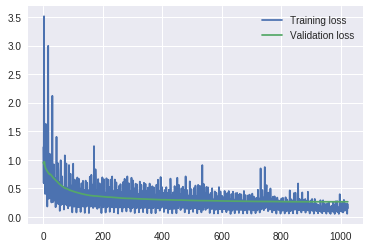

Epoch: 74/100... Step: 1028 train_loss: 0.0974... mean_val_loss: 0.2635
Epoch: 74/100... Step: 1032 train_loss: 0.0927... mean_val_loss: 0.2634
Epoch: 74/100... Step: 1036 train_loss: 0.0680... mean_val_loss: 0.2634
Epoch: 75/100... Step: 1040 train_loss: 0.1128... mean_val_loss: 0.2634


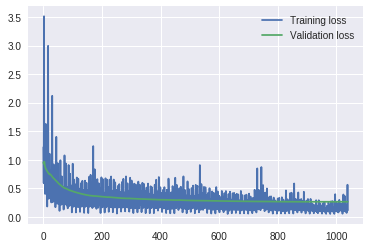

Epoch: 75/100... Step: 1044 train_loss: 0.2448... mean_val_loss: 0.2635
Epoch: 75/100... Step: 1048 train_loss: 0.0980... mean_val_loss: 0.2635
Epoch: 76/100... Step: 1052 train_loss: 0.1420... mean_val_loss: 0.2634
Epoch: 76/100... Step: 1056 train_loss: 0.1140... mean_val_loss: 0.2636


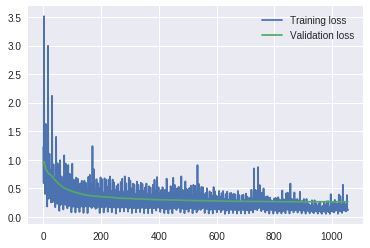

Epoch: 76/100... Step: 1060 train_loss: 0.1324... mean_val_loss: 0.2639
Epoch: 76/100... Step: 1064 train_loss: 0.0713... mean_val_loss: 0.2643
Epoch: 77/100... Step: 1068 train_loss: 0.0934... mean_val_loss: 0.2644
Epoch: 77/100... Step: 1072 train_loss: 0.2564... mean_val_loss: 0.2643


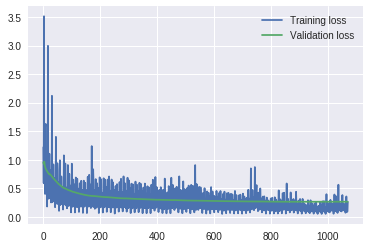

Epoch: 77/100... Step: 1076 train_loss: 0.0738... mean_val_loss: 0.2643
Epoch: 78/100... Step: 1080 train_loss: 0.1021... mean_val_loss: 0.2642
Epoch: 78/100... Step: 1084 train_loss: 0.0920... mean_val_loss: 0.2643
Epoch: 78/100... Step: 1088 train_loss: 0.0882... mean_val_loss: 0.2643


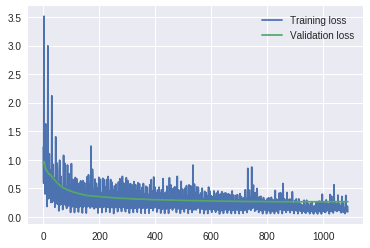

Epoch: 78/100... Step: 1092 train_loss: 0.0579... mean_val_loss: 0.2644
Epoch: 79/100... Step: 1096 train_loss: 0.1018... mean_val_loss: 0.2644
Epoch: 79/100... Step: 1100 train_loss: 0.2064... mean_val_loss: 0.2644
Epoch: 79/100... Step: 1104 train_loss: 0.0761... mean_val_loss: 0.2645


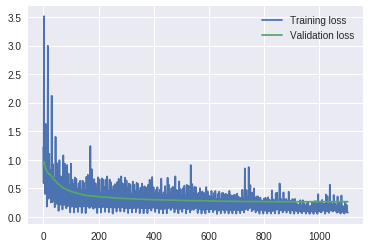

Epoch: 80/100... Step: 1108 train_loss: 0.1117... mean_val_loss: 0.2646
Epoch: 80/100... Step: 1112 train_loss: 0.0834... mean_val_loss: 0.2646
Epoch: 80/100... Step: 1116 train_loss: 0.0729... mean_val_loss: 0.2646
Epoch: 80/100... Step: 1120 train_loss: 0.0482... mean_val_loss: 0.2646


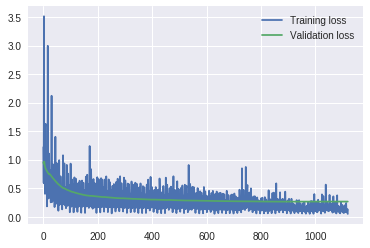

Epoch: 81/100... Step: 1124 train_loss: 0.0738... mean_val_loss: 0.2647
Epoch: 81/100... Step: 1128 train_loss: 0.1878... mean_val_loss: 0.2647
Epoch: 81/100... Step: 1132 train_loss: 0.0681... mean_val_loss: 0.2646
Epoch: 82/100... Step: 1136 train_loss: 0.0908... mean_val_loss: 0.2646


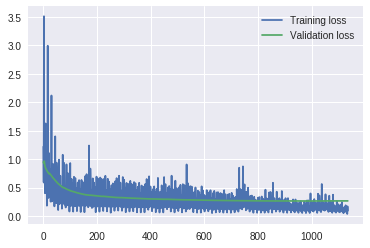

Epoch: 82/100... Step: 1140 train_loss: 0.0827... mean_val_loss: 0.2645
Epoch: 82/100... Step: 1144 train_loss: 0.0808... mean_val_loss: 0.2647
Epoch: 82/100... Step: 1148 train_loss: 0.0474... mean_val_loss: 0.2649
Epoch: 83/100... Step: 1152 train_loss: 0.0777... mean_val_loss: 0.2649


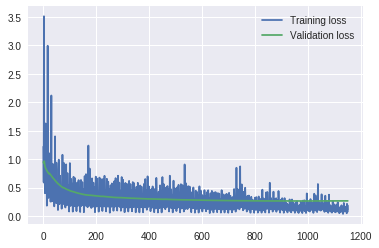

Epoch: 83/100... Step: 1156 train_loss: 0.2435... mean_val_loss: 0.2649
Epoch: 83/100... Step: 1160 train_loss: 0.0971... mean_val_loss: 0.2649
Epoch: 84/100... Step: 1164 train_loss: 0.0786... mean_val_loss: 0.2648
Epoch: 84/100... Step: 1168 train_loss: 0.0842... mean_val_loss: 0.2649


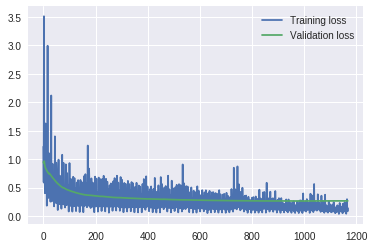

Epoch: 84/100... Step: 1172 train_loss: 0.0749... mean_val_loss: 0.2649
Epoch: 84/100... Step: 1176 train_loss: 0.0607... mean_val_loss: 0.2649
Epoch: 85/100... Step: 1180 train_loss: 0.0804... mean_val_loss: 0.2649
Epoch: 85/100... Step: 1184 train_loss: 0.1550... mean_val_loss: 0.2650


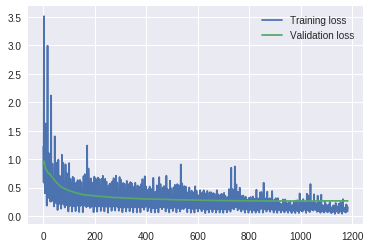

Epoch: 85/100... Step: 1188 train_loss: 0.0934... mean_val_loss: 0.2651
Epoch: 86/100... Step: 1192 train_loss: 0.0935... mean_val_loss: 0.2653
Epoch: 86/100... Step: 1196 train_loss: 0.0859... mean_val_loss: 0.2653
Epoch: 86/100... Step: 1200 train_loss: 0.0653... mean_val_loss: 0.2652


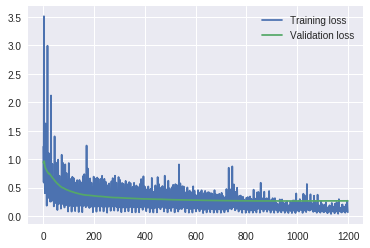

Epoch: 86/100... Step: 1204 train_loss: 0.0472... mean_val_loss: 0.2652
Epoch: 87/100... Step: 1208 train_loss: 0.0732... mean_val_loss: 0.2652
Epoch: 87/100... Step: 1212 train_loss: 0.1359... mean_val_loss: 0.2652
Epoch: 87/100... Step: 1216 train_loss: 0.0639... mean_val_loss: 0.2651


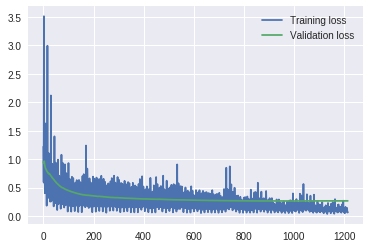

Epoch: 88/100... Step: 1220 train_loss: 0.0909... mean_val_loss: 0.2650
Epoch: 88/100... Step: 1224 train_loss: 0.0847... mean_val_loss: 0.2650
Epoch: 88/100... Step: 1228 train_loss: 0.0860... mean_val_loss: 0.2650
Epoch: 88/100... Step: 1232 train_loss: 0.0508... mean_val_loss: 0.2651


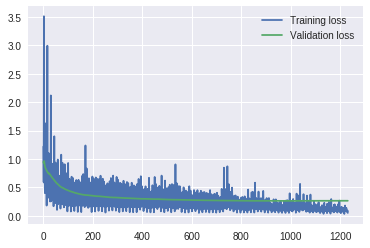

Epoch: 89/100... Step: 1236 train_loss: 0.0789... mean_val_loss: 0.2652
Epoch: 89/100... Step: 1240 train_loss: 0.1615... mean_val_loss: 0.2652
Epoch: 89/100... Step: 1244 train_loss: 0.0592... mean_val_loss: 0.2652
Epoch: 90/100... Step: 1248 train_loss: 0.0699... mean_val_loss: 0.2652


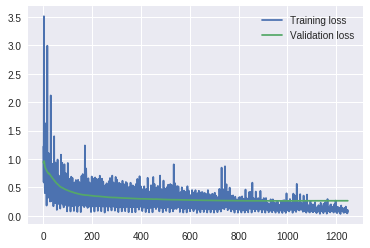

Epoch: 90/100... Step: 1252 train_loss: 0.0641... mean_val_loss: 0.2652
Epoch: 90/100... Step: 1256 train_loss: 0.0552... mean_val_loss: 0.2652
Epoch: 90/100... Step: 1260 train_loss: 0.0413... mean_val_loss: 0.2652
Epoch: 91/100... Step: 1264 train_loss: 0.0661... mean_val_loss: 0.2652


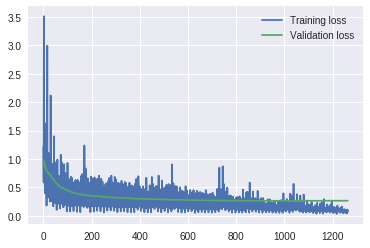

Epoch: 91/100... Step: 1268 train_loss: 0.1482... mean_val_loss: 0.2652
Epoch: 91/100... Step: 1272 train_loss: 0.0593... mean_val_loss: 0.2652
Epoch: 92/100... Step: 1276 train_loss: 0.0735... mean_val_loss: 0.2653
Epoch: 92/100... Step: 1280 train_loss: 0.0529... mean_val_loss: 0.2653


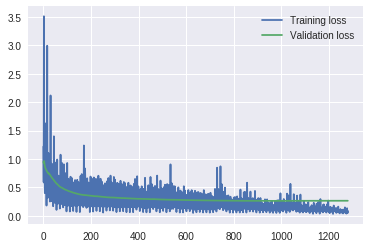

Epoch: 92/100... Step: 1284 train_loss: 0.0655... mean_val_loss: 0.2653
Epoch: 92/100... Step: 1288 train_loss: 0.0331... mean_val_loss: 0.2653
Epoch: 93/100... Step: 1292 train_loss: 0.0669... mean_val_loss: 0.2652
Epoch: 93/100... Step: 1296 train_loss: 0.1134... mean_val_loss: 0.2652


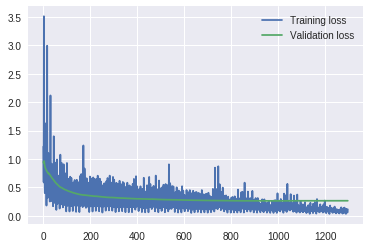

Epoch: 93/100... Step: 1300 train_loss: 0.0602... mean_val_loss: 0.2652
Epoch: 94/100... Step: 1304 train_loss: 0.0644... mean_val_loss: 0.2651
Epoch: 94/100... Step: 1308 train_loss: 0.0545... mean_val_loss: 0.2651
Epoch: 94/100... Step: 1312 train_loss: 0.0459... mean_val_loss: 0.2652


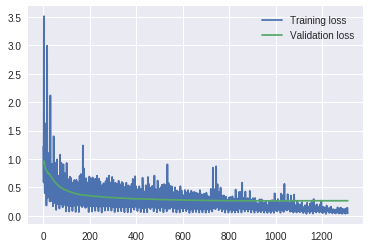

Epoch: 94/100... Step: 1316 train_loss: 0.0406... mean_val_loss: 0.2652
Epoch: 95/100... Step: 1320 train_loss: 0.0700... mean_val_loss: 0.2651
Epoch: 95/100... Step: 1324 train_loss: 0.1222... mean_val_loss: 0.2651
Epoch: 95/100... Step: 1328 train_loss: 0.0700... mean_val_loss: 0.2651


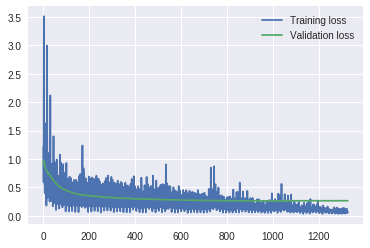

Epoch: 96/100... Step: 1332 train_loss: 0.0718... mean_val_loss: 0.2651
Epoch: 96/100... Step: 1336 train_loss: 0.0565... mean_val_loss: 0.2651
Epoch: 96/100... Step: 1340 train_loss: 0.0551... mean_val_loss: 0.2652
Epoch: 96/100... Step: 1344 train_loss: 0.0288... mean_val_loss: 0.2652


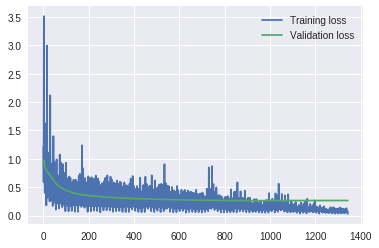

Epoch: 97/100... Step: 1348 train_loss: 0.0785... mean_val_loss: 0.2652
Epoch: 97/100... Step: 1352 train_loss: 0.1221... mean_val_loss: 0.2652
Epoch: 97/100... Step: 1356 train_loss: 0.0724... mean_val_loss: 0.2651
Epoch: 98/100... Step: 1360 train_loss: 0.0861... mean_val_loss: 0.2651


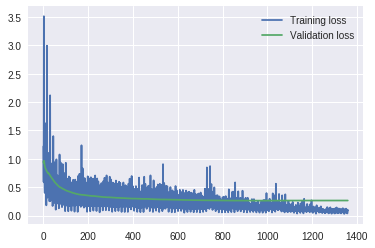

Epoch: 98/100... Step: 1364 train_loss: 0.0600... mean_val_loss: 0.2652
Epoch: 98/100... Step: 1368 train_loss: 0.0527... mean_val_loss: 0.2652
Epoch: 98/100... Step: 1372 train_loss: 0.0340... mean_val_loss: 0.2652
Epoch: 99/100... Step: 1376 train_loss: 0.0665... mean_val_loss: 0.2652


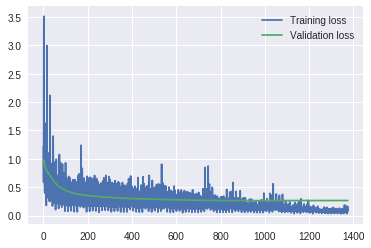

Epoch: 99/100... Step: 1380 train_loss: 0.1489... mean_val_loss: 0.2652
Epoch: 99/100... Step: 1384 train_loss: 0.0951... mean_val_loss: 0.2653
Epoch: 100/100... Step: 1388 train_loss: 0.0758... mean_val_loss: 0.2654
Epoch: 100/100... Step: 1392 train_loss: 0.0690... mean_val_loss: 0.2654


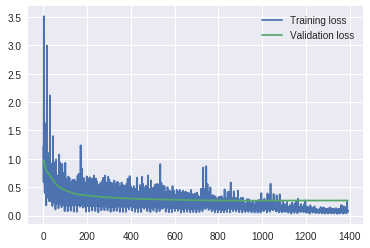

Epoch: 100/100... Step: 1396 train_loss: 0.0665... mean_val_loss: 0.2654
Epoch: 100/100... Step: 1400 train_loss: 0.0354... mean_val_loss: 0.2655


In [32]:
# train the model
cp_name='cp_withtimeperiod.pth'
batch_size = 5
seq_length = 30
n_epochs = 100 # start smaller if you are just testing initial behavior
pmod.train( net, train_data, valid_data, epochs=n_epochs, 
            batch_size=batch_size, seq_length=seq_length, lr=0.001, 
            checkpoint_name=cp_name, train_on_gpu=train_on_gpu)

In [0]:
# load back best model
with open(cp_name, 'rb') as f:
    checkpoint = torch.load(f)
  
net_best = pmod.instantiate_model(checkpoint['input_size'], checkpoint['output_size'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'], train_on_gpu=train_on_gpu)
net_best.load_state_dict(checkpoint['state_dict'])
if(train_on_gpu):
  net_best.cuda()

Use the model with test_data to forecast for the first and the second day.

In [34]:
# check test data
# model to evaluation mode
net_best.eval()
test_losses_MSE = [[], []]
target_list = [[], []]
forecast_list = [[], []]
# during test we simulate the implementation of the deployed usage:
batch_size = 1
seq_length = 1

criterionMSE = nn.MSELoss()

counter = 0
# we will examine the model forecast for the next day where the
# pollution is unknown and for the they after that
# we implement two data-getter for that, one for the first forecast day
# and an other for the next forecast day
batches_day0 = pmod.get_batches(test_data, batch_size, seq_length)
batches_day1 = pmod.get_batches(test_data, batch_size, seq_length)
next(batches_day1)

# data for first forecast day
for inputs_day0, targets_day0 in batches_day0:
    counter+=1
    # break before batches_day1 runs out
    if counter >= len(test_data):
        break
    # data for second forecast day    
    inputs_day1, targets_day1 = next(batches_day1)
    if(train_on_gpu):
      inputs_day0, targets_day0 = inputs_day0.cuda(), targets_day0.cuda()
      inputs_day1, targets_day1 = inputs_day1.cuda(), targets_day1.cuda()

    # calculate forecast for day0
    test_h = net.init_hidden(batch_size)
    output_day0, test_h = net_best(inputs_day0, test_h)
    test_loss_MSE_day0 = criterionMSE(output_day0, targets_day0.view(batch_size*seq_length,-1))
    test_losses_MSE[0].append(test_loss_MSE_day0.item())
    target_list[0].append(targets_day0.item())
    forecast_list[0].append(output_day0.item())

    # need to clone tensor, without this the modification of tensor would affect other data as well
    inputs_day1.data = inputs_day1.clone()
    # we don't change the weather parameters for inputs_day1, because that is our weather forecast,
    # but we change the last number, because that is our pollution forecast from day0
    # our beforday pollution in day1 is the pollution forecast of day0
    inputs_day1[0][0][-1] = output_day0.item()
    # calculate forecast for the day1
    test_h = net.init_hidden(batch_size)
    output_day1, test_h = net_best(inputs_day1, test_h)
    test_loss_MSE_day1 = criterionMSE(output_day1, targets_day1.view(batch_size*seq_length,-1))
    test_losses_MSE[1].append(test_loss_MSE_day1.item())
    target_list[1].append(targets_day1.item())
    forecast_list[1].append(output_day1.item())

print( "test losses MSE for day0: {:.4f}".format(np.mean(test_losses_MSE[0])))
print( "test losses MSE for day1: {:.4f}".format(np.mean(test_losses_MSE[1])))

test losses MSE for day0: 0.3540
test losses MSE for day1: 0.5230


To examine forecast we convert back our data to the original form. This way we get back the μg/m3 numbers. 

In [0]:
# renormalize data to get back the pm10 concentrations
forecast_concentration_day0 = [i * label_std + label_mean for i in forecast_list[0]]
target_concentration_day0 = [i * label_std + label_mean for i in target_list[0]]
abs_error_day0 = [np.abs(a - b) for a, b in zip(forecast_concentration_day0, target_concentration_day0)]

forecast_concentration_day1 = [i * label_std + label_mean for i in forecast_list[1]]
target_concentration_day1 = [i * label_std + label_mean for i in target_list[1]]
abs_error_day1 = [np.abs(a - b) for a, b in zip(forecast_concentration_day1, target_concentration_day1)]

Forecast for day0


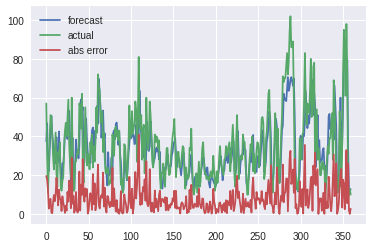

Mean Abs Error day0: 8.320956324159187 μg/m3
Median Abs Error day0: 6.136984242615922 μg/m3
Max Abs Error day0: 40.911949231893885 μg/m3
Forecast for day1


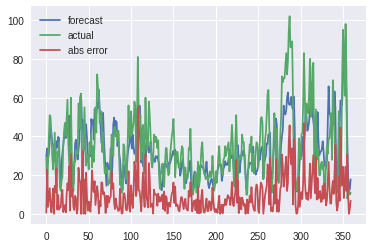

Mean Abs Error day1: 10.130491836825803 μg/m3
Median Abs Error day1: 8.015289445918608 μg/m3
Max Abs Error day1: 55.374131706127294 μg/m3


In [37]:
# plot forecast for day0
print("Forecast for day0")
plt.plot(forecast_concentration_day0, label='forecast')
plt.plot(target_concentration_day0, label='actual')
plt.plot(abs_error_day0, label='abs error')
plt.legend(frameon=False)
plt.show()
# error stats:
print(f"Mean Abs Error day0: {np.mean(abs_error_day0)} μg/m3")
print(f"Median Abs Error day0: {np.median(abs_error_day0)} μg/m3")
print(f"Max Abs Error day0: {np.max(abs_error_day0)} μg/m3")


# plot forecast for day1
print("Forecast for day1")
plt.plot(forecast_concentration_day1, label='forecast')
plt.plot(target_concentration_day1, label='actual')
plt.plot(abs_error_day1, label='abs error')
plt.legend(frameon=False)
plt.show()
# error stats:
print(f"Mean Abs Error day1: {np.mean(abs_error_day1)} μg/m3")
print(f"Median Abs Error day1: {np.median(abs_error_day1)} μg/m3")
print(f"Max Abs Error day1: {np.max(abs_error_day1)} μg/m3")